In [1]:
from utils.CleanData import Operate, filter_language
from utils.FilterData import FilterPara

import argparse
import os
import re
import time
import string
import io
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import torch
import clip
import dask
import dask.array as da

from datetime import datetime
from PIL import Image
from glob import glob
from dask.distributed import Client
from dask import delayed


ModuleNotFoundError: No module named 'clip'

In [ ]:
def show(df):
    print(f"lenth : {len(df)}")
    print(f"{df.head()}")

In [2]:

directory = '/mnt/alluxio/alluxio-fuse/user/tc_agi/klara/datasets/laion2b_en/laion2b_en_20230417112304'
# directory = '/mnt/alluxio/alluxio-fuse/user/tc_agi/klara/datasets/laion2b_multi_chinese_subset/laion2b_multi_chinese_subset'
files = glob(os.path.join(directory, '*.parquet'))
files = [f for f in files if not os.path.basename(f).startswith('.')]
print("-----------------------------------")

-----------------------------------


In [3]:

sample_files = files[:300]
sample_df = dd.read_parquet(sample_files)

min_ratio = 0.9
max_ratio = 1.1

sample_df['RATIO'] = sample_df['WIDTH'] / sample_df['HEIGHT']

filtered_df = sample_df[(sample_df['RATIO'] >= min_ratio) & (sample_df['RATIO'] <= max_ratio)]
filtered_df = filtered_df.drop('RATIO', axis=1)
# filtered_df.head()

In [4]:
min_width, max_width = 128, 1024
min_height, max_height = 128, 1024

filtered_df = filtered_df[(filtered_df['WIDTH'] < max_width) & (filtered_df['HEIGHT'] < max_height)]
filtered_df = filtered_df[(filtered_df['WIDTH'] > min_width) & (filtered_df['HEIGHT'] > min_height)]

In [5]:
min_length, max_length = 16,1024
df_len = filtered_df
df_len= df_len[(df_len['TEXT'].str.len() >= min_length) & (df_len['TEXT'].str.len() <= max_length)]

In [6]:
# need 36hours to process all data

df = df_len
df['TEXT'] = df['TEXT'].map(Operate, meta=('TEXT', 'object'))
# df_removed = df[~df['TEXT'].apply(FilterPara, meta=('TEXT', 'bool'))]
# df = df[df['TEXT'].apply(FilterPara, meta=('TEXT', 'bool'))]
filtered_lang_df = df[df['TEXT'].apply(filter_language, meta=('TEXT', 'bool'))]

In [7]:
Operate('盤')
pd.set_option('display.max_colwidth', 1024)


In [8]:
import clip
df_clip = filtered_lang_df.compute()
# df = filtered_df
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("/mnt/data/user/tc_agi/multi_modal/checkpoints/clip/ViT-B-16.pt", device=device)
print("-------------------------")

In [ ]:
# df = result
# df = df.set_index('SAMPLE_ID')
# if df.index.is_unique:
#     print("The sampleid index is unique.")
# else:
#     print("The sampleid index is not unique.")



The sampleid index is unique.


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3200
3200
3200
2489
3200


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3200
3200
3200
2489


In [ ]:
# import pandas as pd

# loaded_df = pd.read_parquet('saved_data.parquet')


In [ ]:
import sys
 
def process_image(row):
    try:
        img = Image.open(io.BytesIO(row['BUFFER']))
        tensor = preprocess(img).to(device)
        return tensor, row
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

global_partition_counter = 0
import threading
gpu_lock = threading.Lock()

def compute_embeddings(partition, batch_size=3200):
    global global_partition_counter
    with gpu_lock:

        all_embeddings = []
        valid_rows = []  # To collect rows of valid images

        for start in range(0, len(partition), batch_size):
            end = start + batch_size
            batch = partition.iloc[start:end]
            # if global_partition_counter % 20 == 0:
                    # print(len(batch))
            print(len(batch))
            processed_tensors = []
            for _, row in batch.iterrows():
                tensor, valid_row = process_image(row)
                if tensor is not None:
                    processed_tensors.append(tensor)
                    valid_rows.append(valid_row)

            tensor_stack = torch.stack(processed_tensors)
            
            with torch.no_grad():
                embedding = model.encode_image(tensor_stack)
            all_embeddings.extend(embedding.cpu().numpy())


        valid_partition = pd.concat(valid_rows, axis=1).transpose()
        valid_partition['CLIP_Features'] = all_embeddings

        global_partition_counter += 1
        return valid_partition


# import dask.dataframe as dd
desired_rows_per_partition = 6000
# def custom_partition(df, rows_per_partition):
#     npartitions = -(-len(df) // rows_per_partition) 
    
#     partitions = []
#     for i in range(npartitions):
#         start_idx = i * rows_per_partition
#         end_idx = min((i + 1) * rows_per_partition, len(df))
#         partitions.append(df.iloc[start_idx:end_idx])
    
#     return partitions


# partitions = custom_partition(df_clip, 6000)
# ddf_partitions = [dd.from_pandas(part, npartitions=1) for part in partitions]

# df_clip = dd.concat(ddf_partitions, interleave_partitions=True)

npartitions = len(df_clip) // desired_rows_per_partition
df_clip = dd.from_pandas(df_clip, npartitions=npartitions)
df_clip = df_clip.map_partitions(compute_embeddings, meta=df_clip._meta.assign(CLIP_Features='f8'))
result = df_clip.compute()

# 8*A800 -> 11days


1


1
9
28
3200


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3200
3200
3200
2489


In [ ]:
df1 = result
df1 = df1.set_index('SAMPLE_ID')
df1['CLIP_Features'] = df1['CLIP_Features'].apply(lambda x: np.array(x).astype('float32') if isinstance(x, (list, np.ndarray)) else x)

# 选择'SAMPLE_ID'和'CLIP_Features'
df_to_save = df1[['CLIP_Features']]

# 保存为Parquet文件
df_to_save.to_parquet('saved_data.parquet')


In [6]:
# def filter_language(text):
#     with open("not_in_vocab_chinese.txt", "a", encoding="utf-8") as file:
#         whitespace_chars = set([" ", "\t", "\n", "\r", "\f", "\v", "\u00A0", "\u2028", "\u2029", "\u3000"])
#         for char in text:
#             if char in whitespace_chars:
#                 continue
#             if char not in vocab:
#                 file.write(f'[{char}] is not in vocab : {text}\n')
#                 return not False
#     return not True


In [10]:
len(result)
# result.head()
len(filtered_lang_df)


917624

In [ ]:
# import clip
# from PIL import Image
# from io import BytesIO
# import torch
# import pandas as pd

# device = "cuda" if torch.cuda.is_available() else "cpu"
# # model, preprocess = clip.load("/mnt/data/user/tc_agi/multi_modal/checkpoints/clip/ViT-L-14.pt", device=device)
# model, preprocess = clip.load("/mnt/data/user/tc_agi/multi_modal/checkpoints/clip/ViT-B-16.pt", device=device)

# MAX_TOKENS = 77  
# # 
# def truncate_text(text, model=clip, max_tokens=MAX_TOKENS):
#     truncated_text = text
#     while True:
#         try:
#             tokens = model.tokenize([truncated_text])
#             if len(tokens[0]) <= max_tokens:
#                 return truncated_text
            
#         except RuntimeError:  
#             pass

#         truncated_text = ' '.join(truncated_text.split()[:-1])

# def calculate_clip_score(row):
#     image = Image.open(BytesIO(row['BUFFER']))
#     processed_image = preprocess(image).unsqueeze(0).to(device)

#     text_description = row['TEXT']
#     truncated_description = truncate_text(text_description)
#     text = clip.tokenize([truncated_description]).to(device)
    
#     with torch.no_grad():
#         image_features = model.encode_image(processed_image)
#         text_features = model.encode_text(text)
#     cos = torch.nn.CosineSimilarity(dim=1)
#     similarity = cos(image_features, text_features)
#     return similarity[0]

# filtered_df['CLIP_SCORE'] = filtered_df.apply(lambda row: calculate_clip_score(row), axis=1, meta=('float'))

# # result = filtered_df.compute()


In [ ]:
# import matplotlib.pyplot as plt

# clip_score_series = filtered_df['CLIP_SCORE'].compute()

# clip_score_series.hist()
# plt.xlabel('CLIP_SCORE')
# plt.ylabel('Frequency')
# plt.show()



In [ ]:
# import dask.dataframe as dd
# import pandas as pd
# import torch
# from PIL import Image
# import io
# import clip

# df = filtered_lang_df
# # df = filtered_df
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("/mnt/data/user/tc_agi/multi_modal/checkpoints/clip/ViT-B-16.pt", device=device)

# def generate_batches_from_dask_df(ddf, batch_size):
#     num_partitions = ddf.npartitions
#     for i in range(num_partitions):
#         small_df = ddf.get_partition(i).compute()
#         for start in range(0, len(small_df), batch_size):
#             end = start + batch_size
#             yield small_df.iloc[start:end]

# final_dfs = [] # List to store concatenated dataframes

# print("---------------------------------------------")
# for batch in generate_batches_from_dask_df(df, batch_size=4000):
#     print(f"len: {len(batch)}")
#     images = [Image.open(io.BytesIO(row['BUFFER'])) for _, row in batch.iterrows()]
#     tensor = torch.stack([preprocess(img) for img in images]).to(device)
#     with torch.no_grad():
#         embedding = model.encode_image(tensor)
    
#     embedding_df = pd.DataFrame(embedding.cpu().numpy())
    
#     concatenated_df = pd.concat([batch.reset_index(drop=True), embedding_df], axis=1)
#     final_dfs.append(concatenated_df)

# result_df = pd.concat(final_dfs).reset_index(drop=True)


In [ ]:
df_check = filtered_lang_df
def check_image_integrity(data):
    try:
        img = Image.open(io.BytesIO(data))
        img.verify()  # 验证图像的完整性
        return False
    except OSError:
        return True

def check_images_integrity(partition):
    partition['Corrupted'] = partition['BUFFER'].apply(check_image_integrity)
    return partition

# Update the metadata for the new 'Corrupted' column
meta = df_check._meta.assign(Corrupted=pd.Series([False], dtype=bool))

df_check = df_check.map_partitions(check_images_integrity, meta=meta)


In [44]:
df_check = filtered_lang_df
def check_images_integrity(partition, batch_size=4000):
    corrupted_flags = []
    for start in range(0, len(partition), batch_size):
        end = start + batch_size
        batch = partition.iloc[start:end]
        for _, row in batch.iterrows():
            data = row['BUFFER']
            # if not isinstance(data, (bytes, bytearray)):
                # corrupted_flags.append(True)
                # continue
            try:
                img = Image.open(io.BytesIO(data))
                img.verify()  
                corrupted_flags.append(False)
            except OSError:
                corrupted_flags.append(True)
    partition['Corrupted'] = corrupted_flags
    return partition

# Update the metadata for the new 'Corrupted' column
meta = df_check._meta.assign(Corrupted=pd.Series([False], dtype=bool))

df_check = df_check.map_partitions(check_images_integrity, meta=meta)



In [45]:
corrupted_df = df_check[df_check['Corrupted'] == True].compute()

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes sh

In [46]:
corrupted_df.head()

SAMPLE_ID   
6823  2.472431e+12  \
3386  2.576536e+12   
7903  4.186990e+12   
1006  3.674660e+12   

                                                                                                                                URL   
6823                                                       https://www.chattanoogastate.edu/sites/default/files/handprints-test.png  \
3386                                         http://bethannwilliams.com/wp-content/uploads/2013/07/A-Celtic-Celebration-270x300.png   
7903  https://cdn.shopify.com/s/files/1/0016/4390/5137/products/Ring_1_1_cb413e7e-15f1-4b20-8aef-8d2c673f1e90_960x.png?v=1614681683   
1006                                        https://www.topsnowshop.de/Files/7/115000/115539/ProductPhotos/MaxContent/666745722.png   

                                                                              TEXT   
6823                                                   Colorful painted handprints  \
3386  A Celtic Celebration, quilt designed and made by Beth Ann Williams, (C) 2000   
7903                                                        Gold Pigger Ring Women   
1006                                          cp_skihelm_Cuma_black-s.t._polarized   

      HEIGHT  WIDTH LICENSE      NSFW  similarity   
6823     276    298       ?  UNLIKELY    0.325477  \
3386     300    270       ?  UNLIKELY    0.326162   
7903     960    960       ?  UNLIKELY    0.314278   
1006     300    300       ?  UNLIKELY    0.313871   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               BUFFER   
6823  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01*\x00\x00\x01\x14\x08\x02\x00\x00\x00\x13(\xec\xa5\x00\x00\x00\x19tEXtSoftware\x00Adobe ImageReadyq\xc9e<\x00\x02piIDATx\xda<\xbd\xf9\xafe\xd9u\x1e\xb6\xa73\x9fs\xa77\xbfz5W\xf5\xc4\xee&\x9bM5I\x89\xa2B\xca\x92\x1d\x0f"a\x1b\xb0cCq\x82\x00N\x02\x07\x08\x90\xe4\x0f\t\x90\xdf\x02\x04\x0e\x12\'\x81\x05DI\x0c\xd9\x0e"\xcbT,\x93\x96D\x91=\xb0\xc7\xea\x9a\x877\xdf\xf9\xccg\x0f\xf9\xd6\xb9\xc5TW\xbf~\xef\xbes\xcf\xddg\xef\xb5\xbe\xf5}k\xaf\xb5\x9b\xbf\xf8\xf8\x7f\xe6\xdc0\xe68g\x9c[\xe7\x94sVp\xc18cL2\xd60\'\x04sx\x11\x170\x8eW8\x93\xf2\xf1\xbd\xfa\'?\xbe,\xea\xe8p?d\x8e\xcd\x96r\xd5\xaa\xb2\xd2\x81/\xa5dJ\xc9\xf3E\xb9,:\\\x1bG\x81r\\r\xe7I6N\xfd\x83]\xaf5]\xe0\xb9+\xbb\xfc\xea\x8d(\x08E\xd75O\x1ez\x17\x97\xda8\xf1\xe8\xa4\x11\xbeb\xb6\x8d"\x95\xa5\xfe\xc5l\xd6Z\x19\xf0\xf6\xc6U\xf3\xbd\xef\x1eD\x81o\x0c\r\x05#\xc3\xa08\xc77\x02\x83\xb2\xf8\x89{\x8ciKc\x14\xf8-\x17\xb8N*%\xfe\xe8\xff>\xfb\xef\x7f\xff\x897\x1c\xc5\x91\xac\x9bF\xe3\x91\xba\xfa\xf5\x9b\xdb\xb5\xf5\xf...  \
3386  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x0e\x00\x00\x01,\x08\x06\x00\x00\x002\xd5]\x98\x00\x00 \x00IDATx\x9c\xb4\xbc\xd7\x93\'\xcbu\xe7\xf7\xc9\xf2?\xef\x7f\xed\xfd\xf4\xf8\xb93s\xfd\xe0\x1a\x00\x84!\t\x80\\:q%*\xa8\x906$\x05\x1f$\x85\x9e\xf4\xa2\x05\x85\x17\xfd\x03\xd2\x8bB\x11Tp\x97\\q\x97Kr\x01\x12 @\xf8\xeb\xbd\x1d\xd33\xd3\xdd\xd3\xde\xfd\xbc\xab_\xf9J=\xccLO\xf7\xcc\\\x00\xab\x90\xb2#\xba\xab2O\x9e<y\xf2\x9c\xef9\x99U\xd5\xc2\x8b|)\x

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


TypeError: Image data of dtype object cannot be converted to float

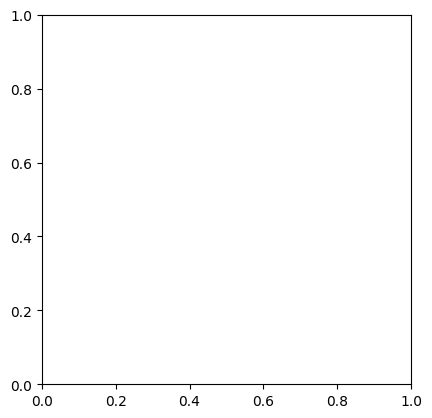

In [49]:
import matplotlib.pyplot as plt
import io
from PIL import Image

# 为corrupted_df中的每个BUFFER数据绘制图像
for idx, row in corrupted_df.iterrows():
    buffer_data = row['BUFFER']
    # try:
    img = Image.open(io.BytesIO(buffer_data))
    plt.imshow(img)
    plt.title(f"Image at index {idx}")
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
    # except Exception as e:
    #     print(f"Image at index {idx} is corrupted: {e}")



In [42]:
df_clip = filtered_lang_df
# df = filtered_df
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("/mnt/data/user/tc_agi/multi_modal/checkpoints/clip/ViT-B-16.pt", device=device)
print("-------------------------")


-------------------------


In [26]:




def compute_embeddings(partition, batch_size=4000):
    all_embeddings = []
    for start in range(0, len(partition), batch_size):
        end = start + batch_size
        batch = partition.iloc[start:end]
        print(len(batch))
        images = [Image.open(io.BytesIO(row['BUFFER'])) for _, row in batch.iterrows()]
        tensor = torch.stack([preprocess(img) for img in images]).to(device)
        with torch.no_grad():
            embedding = model.encode_image(tensor)
        all_embeddings.extend(embedding.cpu().numpy())
    partition['CLIP_Features'] = all_embeddings
    return partition

df_clip = df_clip.map_partitions(compute_embeddings, meta=df_clip._meta.assign(CLIP_Features='f8'))
df_clip.compute()
# df = df.compute()


-------------------------


In [ ]:
df_clip = filtered_lang_df
    
def safe_open(data):
    """
    尝试使用PIL来打开图像，如果成功则返回图像，否则返回None
    """
    try:
        img = Image.open(io.BytesIO(data))
        img.verify()  # 验证图像的完整性
        return img
    except Exception:
        return None

def compute_embeddings_with_exceptions(partition, batch_size=4000):
    all_embeddings = []

    # 使用矢量化方法处理图像
    partition['Image'] = partition['BUFFER'].apply(safe_open)

    # 标记异常
    partition['Is_Exception'] = partition['Image'].isnull()

    # 仅获取有效图像的列表
    valid_images = partition.loc[~partition['Is_Exception'], 'Image'].tolist()

    for start in range(0, len(valid_images), batch_size):
        end = start + batch_size
        batch_images = valid_images[start:end]

        processed_images = []
        for img in batch_images:
            try:
                processed_img = preprocess(img)  # 这里进行预处理
                processed_images.append(processed_img)
            except Exception:
                # 如果在预处理阶段发生异常，可以在这里处理，但对于您的用例，可能不需要
                pass

        print(f"Processing {len(processed_images)} tensors out of {len(batch_images)} in the batch.")

        if processed_images:
            tensor = torch.stack(processed_images).to(device)
            with torch.no_grad():
                embedding = model.encode_image(tensor)
            all_embeddings.extend(embedding.cpu().numpy())

    # 将计算出的嵌入添加到原始分区上
    partition['CLIP_Features'] = all_embeddings[:len(partition)]
    
    # 清理已不再需要的Image列
    partition = partition.drop(columns=['Image'])
    return partition

# 更新metadata以包括新的CLIP_Features列
meta = df_clip._meta.assign(CLIP_Features=pd.Series(dtype='object'))

df_clip = df_clip.map_partitions(compute_embeddings_with_exceptions, meta=meta).compute()

# 如果你需要获得所有的异常行，你可以这样操作:
all_exceptions = df_clip[df_clip['Is_Exception']].index


In [ ]:
print("Rows with exceptions:", all_exceptions)


Rows with exceptions: []


In [12]:
# df_pandas = df_clip.compute()
df_pandas = result
df_pandas = df_pandas.set_index('SAMPLE_ID')



In [13]:
df_pandas.head(10)

URL   
SAMPLE_ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
3126340012240.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    https://www.specsserver.com/CACHE/FRMNBGUDREVU.JPG?width=220&height=220&ccid=x49a24480  \
2789687003305.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             https://www.imageserverhost.com/simg/C122/500x500/1214382.jpg   
2642710002088.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                http://img.burrillandco.com/nimg/4a/cd/2aac93c74887ea13c85454816332-150x150-0/china_reliable_manufacturer_pu_foam_sandwich_wall_panels.jpg   
3956940008889.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               https:/

In [14]:
import faiss
import numpy as np

embeddings_matrix = np.vstack(df_pandas['CLIP_Features'].to_list()).astype('float32')  

# 如果embeddings未被归一化，请进行归一化
faiss.normalize_L2(embeddings_matrix)

index = faiss.IndexFlatL2(embeddings_matrix.shape[1])  
index.add(embeddings_matrix)

# 对每个embedding搜索其最近邻
D, I = index.search(embeddings_matrix, embeddings_matrix.shape[0])


threshold = 0.96  # 余弦相似度的阈值
similar_pairs = []

for i in range(I.shape[0]):
    similarities = 1 - D[i] / 2  # 将L2距离转换为余弦相似度
    filtered_sample_ids = df_pandas.index[I[i][(similarities > threshold) & (I[i] != i)]].tolist()
    if filtered_sample_ids:
        similar_pairs.append((df_pandas.index[i], filtered_sample_ids))




: 

: 

In [ ]:
import faiss
import numpy as np

# 1. 准备数据
embeddings_matrix = np.vstack(df_pandas['CLIP_Features'].to_list()).astype('float32')  
faiss.normalize_L2(embeddings_matrix)

# 2. 创建和训练索引
nlist = 100
quantizer = faiss.IndexFlatL2(embeddings_matrix.shape[1])
index_cpu = faiss.IndexIVFFlat(quantizer, embeddings_matrix.shape[1], nlist, faiss.METRIC_L2)

# 使用GPU资源
res = faiss.StandardGpuResources()
index = faiss.index_cpu_to_gpu(res, 0, index_cpu)

# 训练索引
assert not index.is_trained
index.train(embeddings_matrix)
assert index.is_trained

index.add(embeddings_matrix)

# 3. 搜索
k = 100  # 只搜索最近的100个邻居
D, I = index.search(embeddings_matrix, k)

# 4. 过滤满足阈值条件的邻居
threshold = 0.98
similar_pairs = []

for i in range(I.shape[0]):
    similarities = 1 - D[i] / 2  # 将L2距离转换为余弦相似度
    filtered_sample_ids = df_pandas.index[I[i][(similarities > threshold) & (I[i] != i)]].tolist()
    if filtered_sample_ids:
        similar_pairs.append((df_pandas.index[i], filtered_sample_ids))


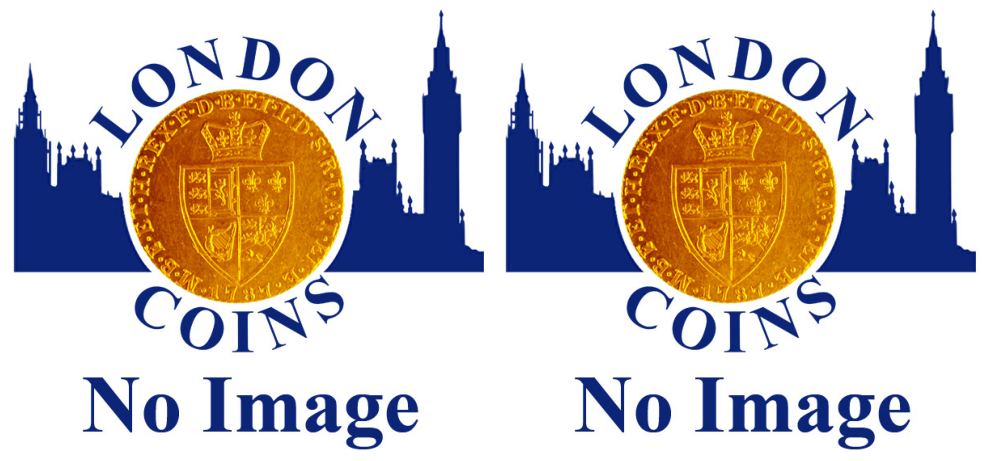

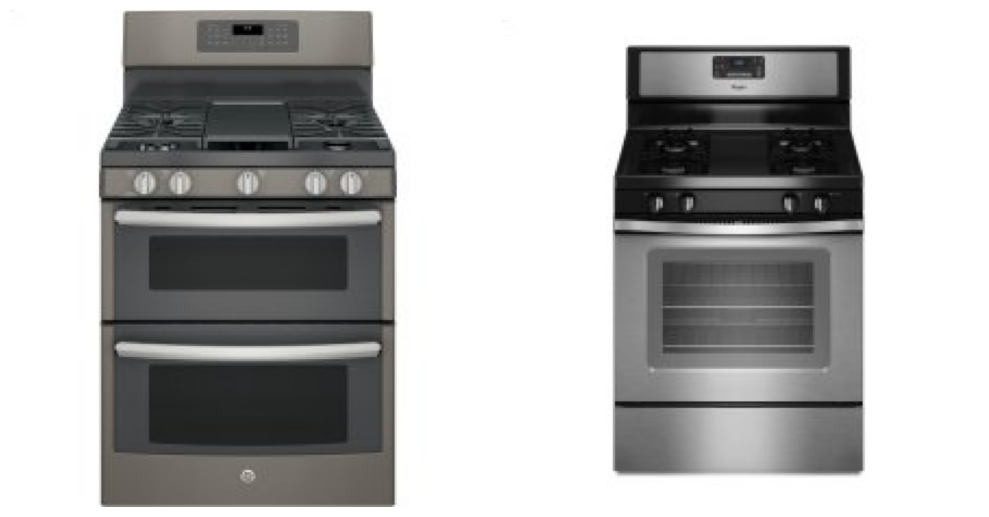

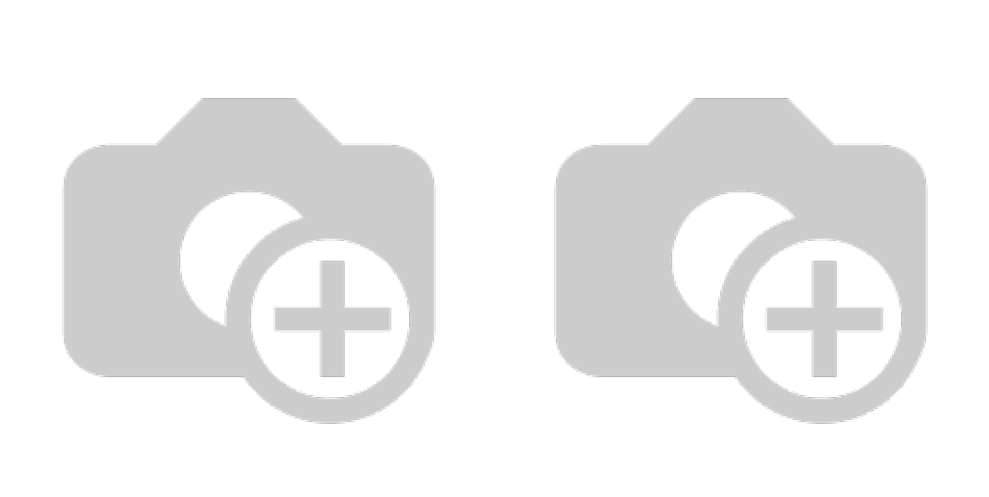

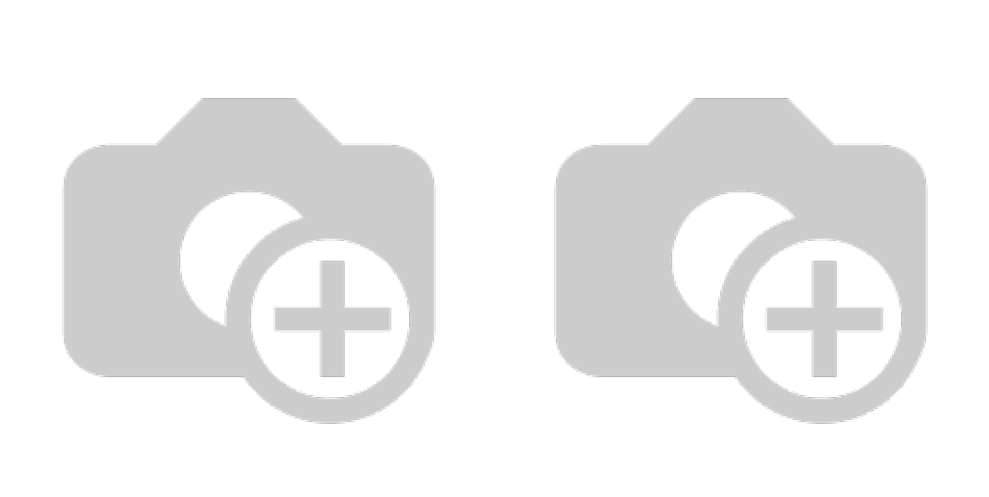

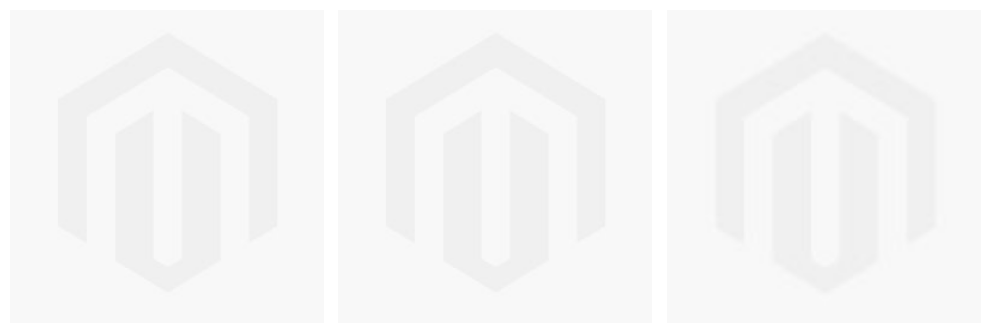

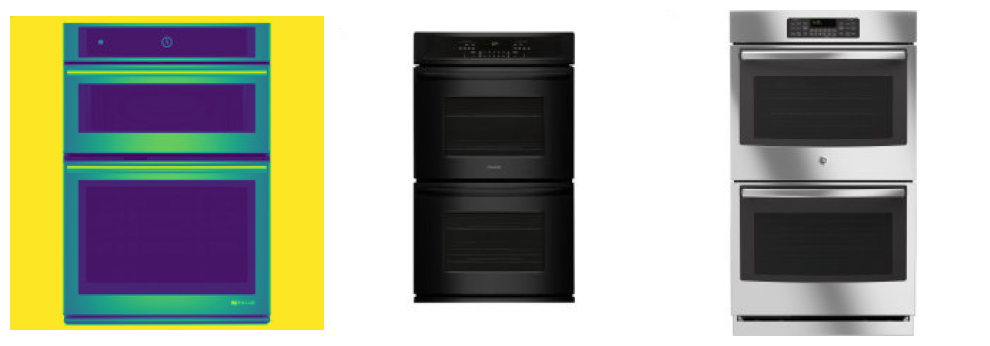

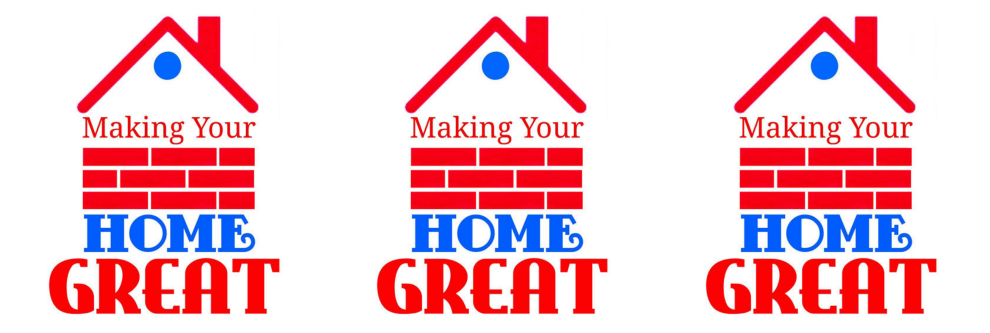

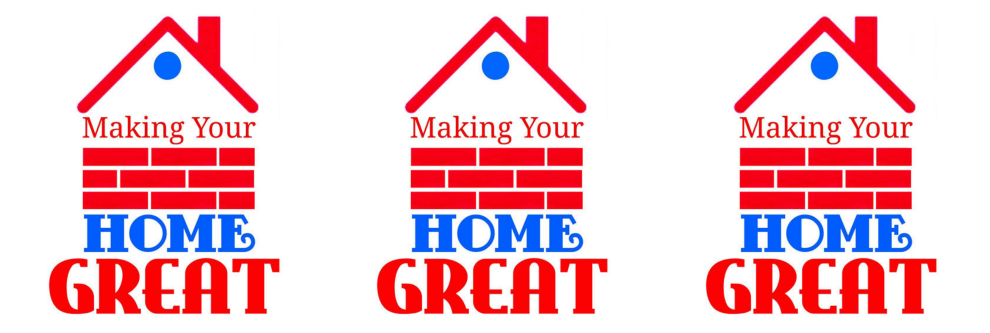

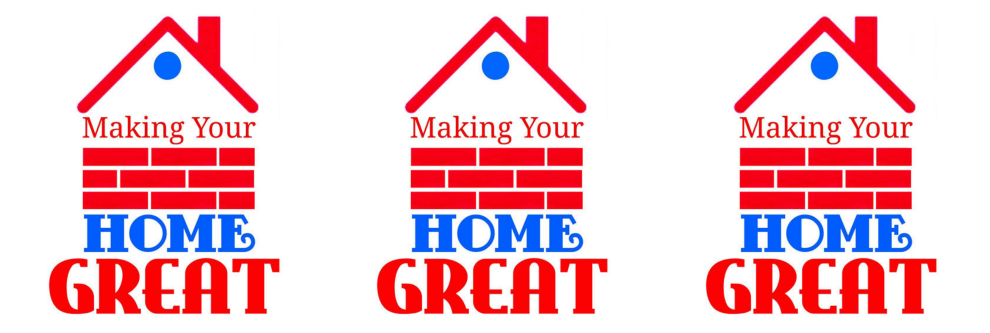

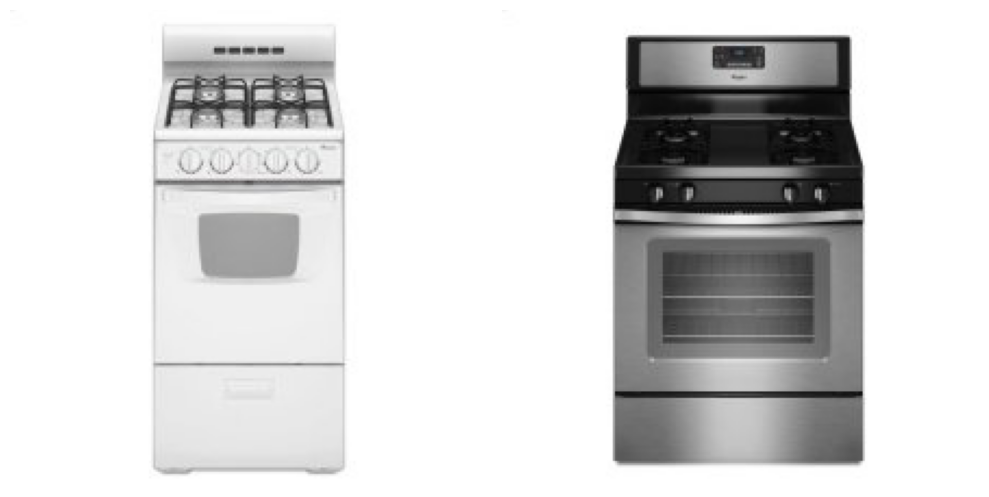

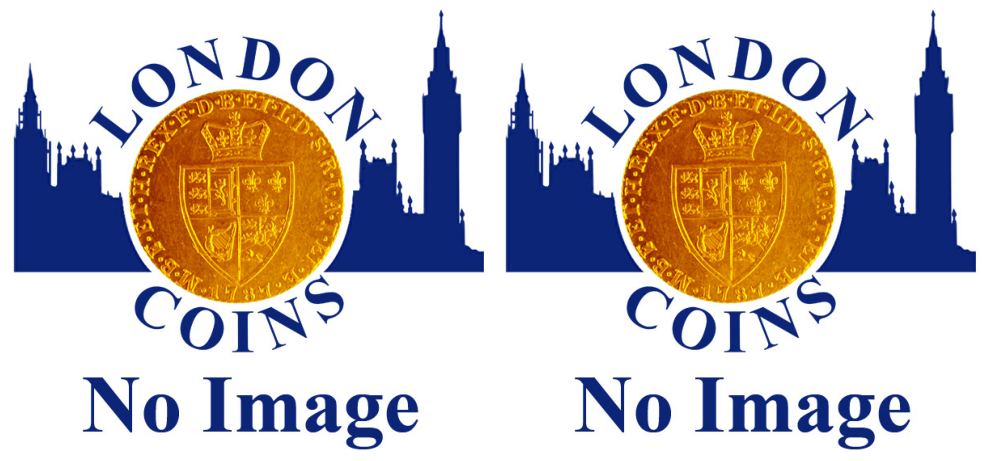

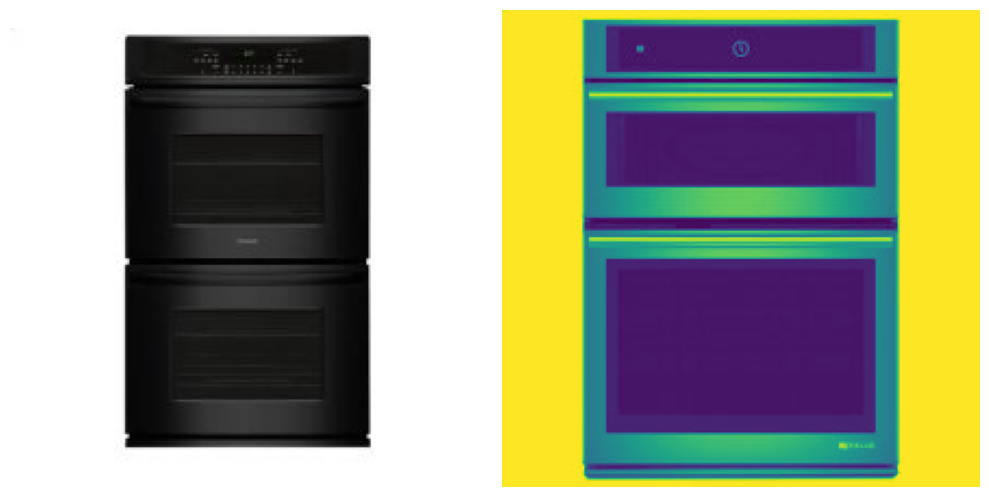

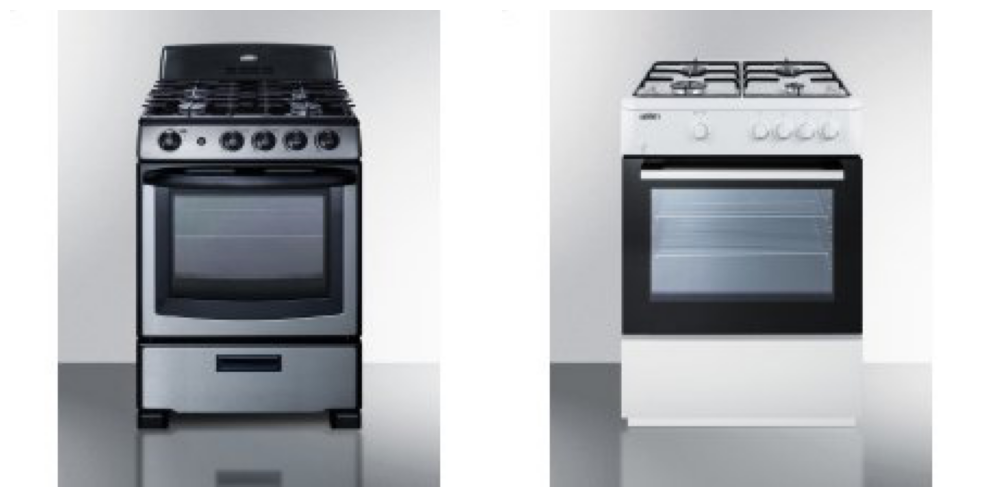

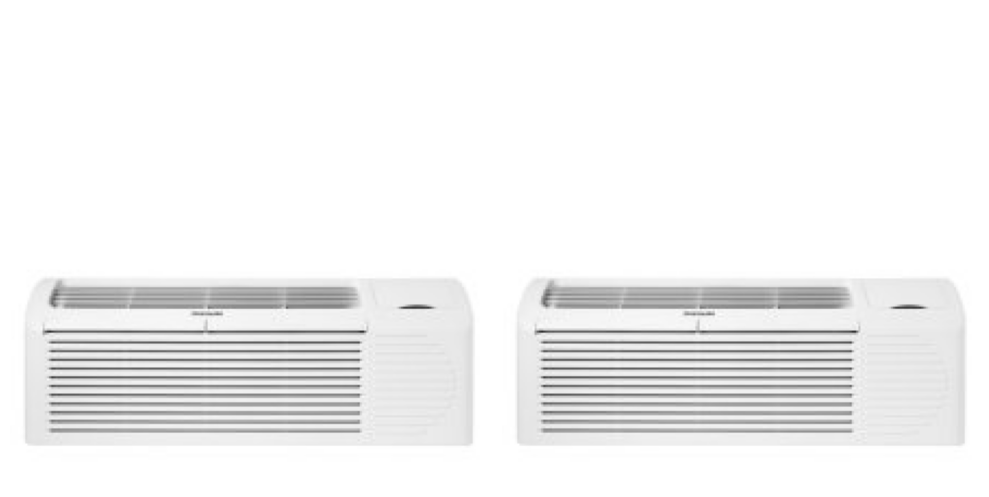

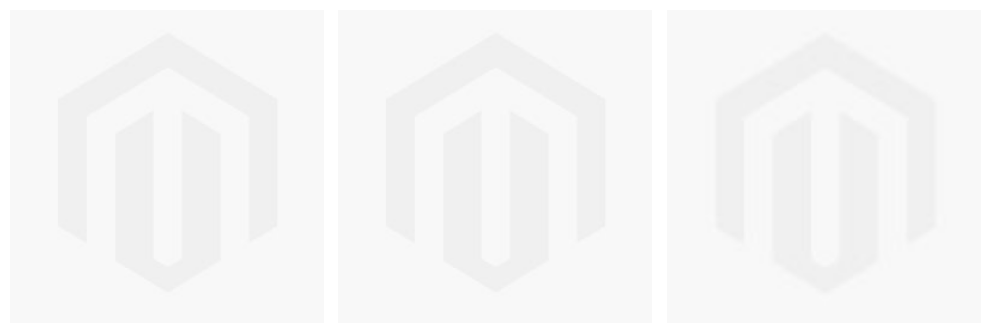

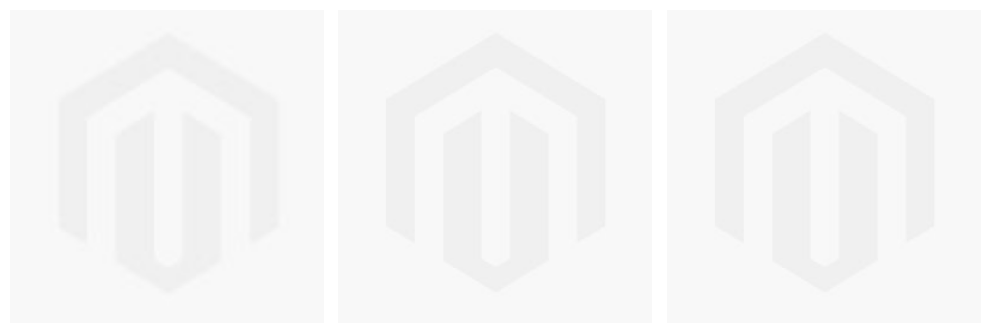

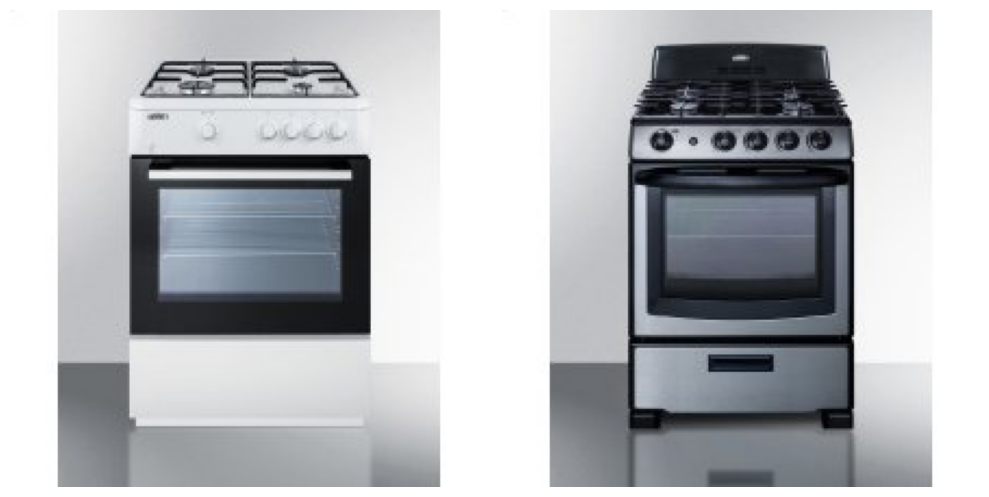

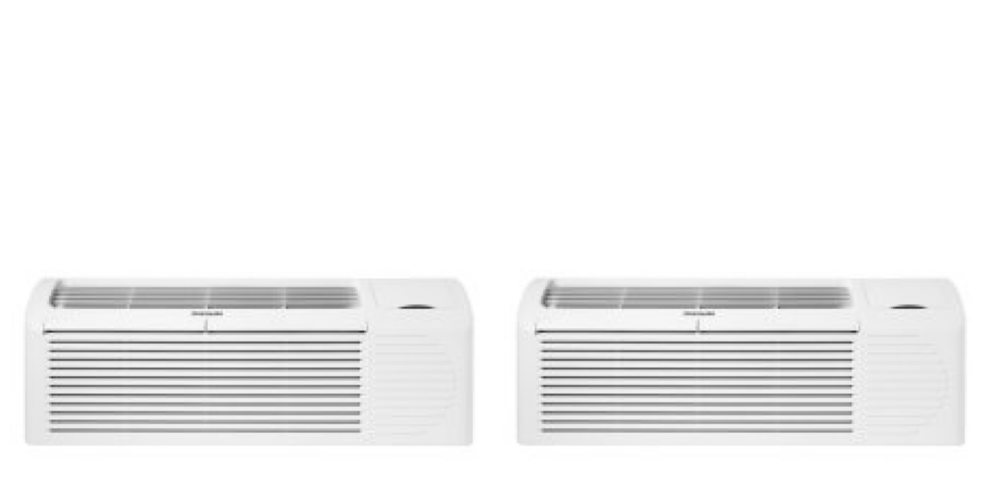

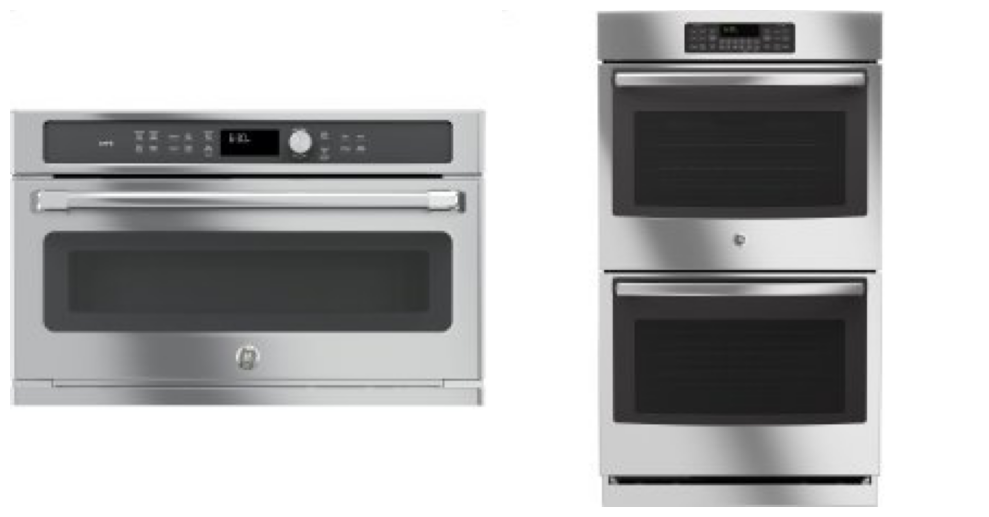

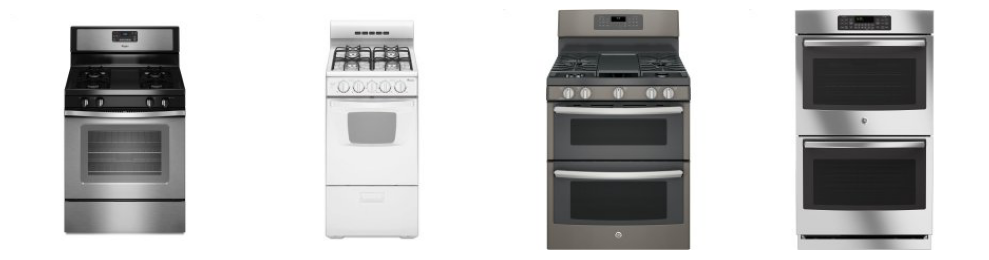

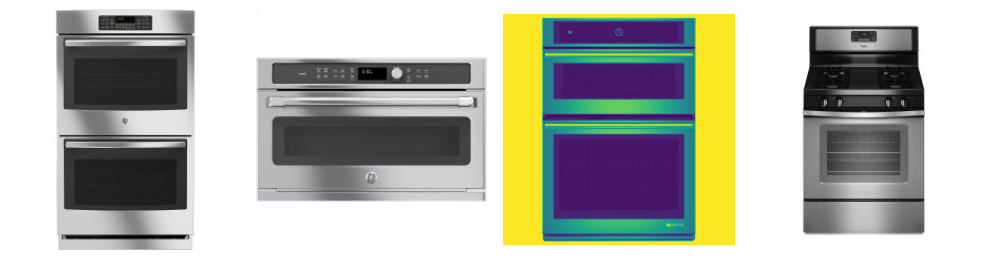

In [ ]:
from PIL import Image
import io
import matplotlib.pyplot as plt

def retrieve_and_show_images(sample_id1, similar_sample_ids, dataframe, max_similar=5):
    # 确保不显示与自己相似的图像
    similar_sample_ids = [sid for sid in similar_sample_ids if sid != sample_id1]
    
    image1 = Image.open(io.BytesIO(dataframe.loc[sample_id1]['BUFFER']))
    plt.figure(figsize=(10, 10))
    plt.subplot(1, min(len(similar_sample_ids), max_similar) + 1, 1)
    plt.imshow(image1)
    plt.axis('off')
    
    for j, sample_id2 in enumerate(similar_sample_ids[:max_similar], start=2): # 只显示前max_similar个相似图像
        image2 = Image.open(io.BytesIO(dataframe.loc[sample_id2]['BUFFER']))
        plt.subplot(1, min(len(similar_sample_ids), max_similar) + 1, j)
        plt.imshow(image2)
        plt.axis('off') # 移除坐标轴
        
    plt.tight_layout()
    plt.show()

for idx, (sample_id1, similar_sample_ids) in enumerate(similar_pairs):
    if idx >= 40:  # 只显示前十行
        break
    retrieve_and_show_images(sample_id1, similar_sample_ids, df_pandas)


In [ ]:
duplicated_rows = df_pandas[df_pandas['SAMPLE_ID'].duplicated(keep=False)]
# print(duplicated_rows)
duplicated_rows_sorted = duplicated_rows.sort_values(by="SAMPLE_ID")
print(duplicated_rows_sorted)


3442
3456


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/tmp/ipykernel_5163/4156809616.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partition['CLIP_Features'] = all_embeddings
/tmp/ipykernel_5163/4156809616.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partition['CLIP_Features'] = all_embeddings
/home/jeeves/.local/lib/python3.10/site-packages/dask/dataframe/core.py:4918: Use

3442
3442
3456
3456


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/tmp/ipykernel_5163/4156809616.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partition['CLIP_Features'] = all_embeddings
/home/jeeves/.local/lib/python3.10/site-packages/dask/core.py:121: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.00 GiB (GPU 0; 79.32 GiB total capacity; 32.46 GiB already allocated; 2.88 GiB free; 39.39 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

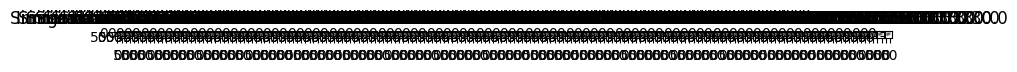

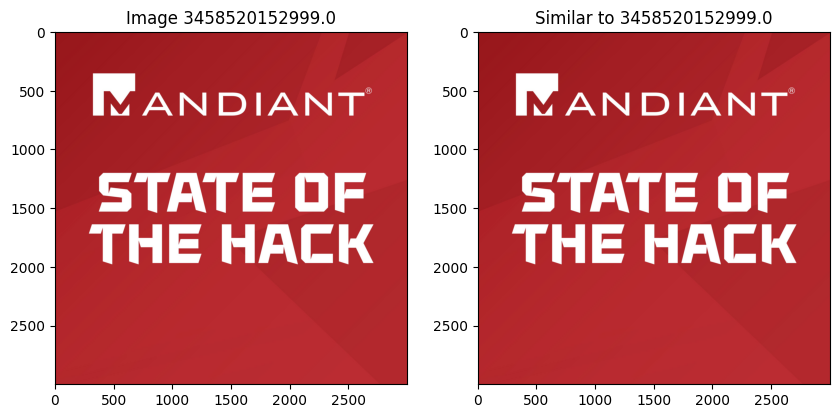

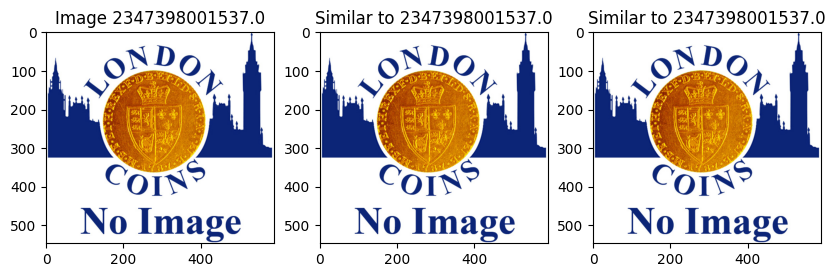

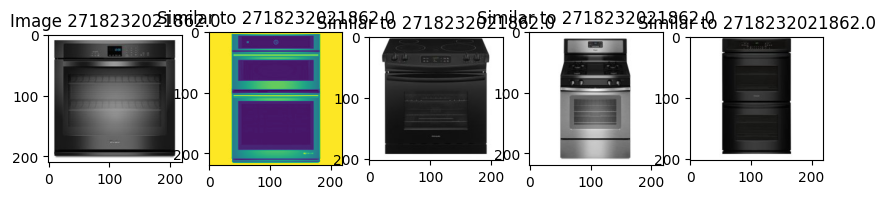

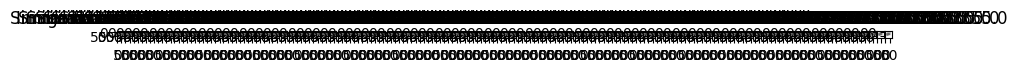

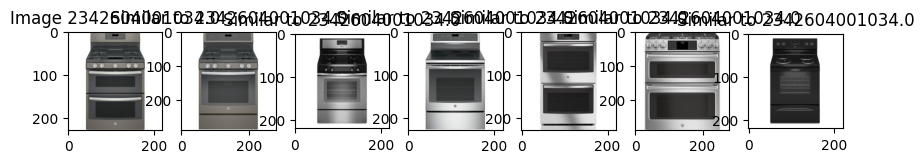

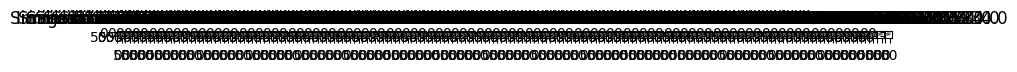

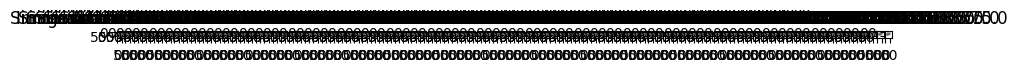

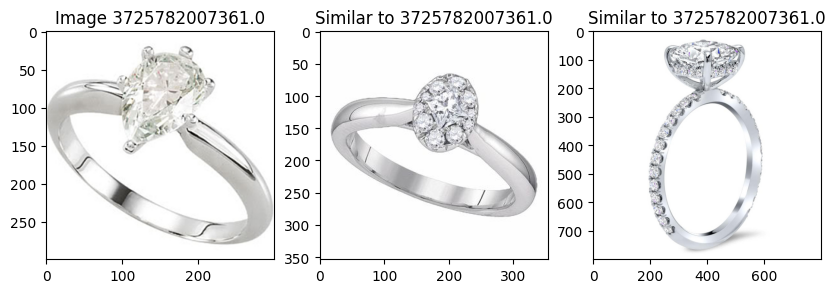

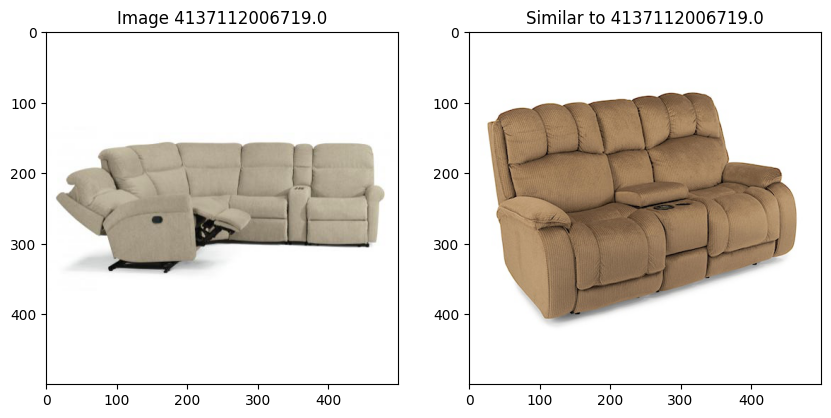

In [ ]:
from PIL import Image
import io
import matplotlib.pyplot as plt

def retrieve_and_show_images(sample_id1, similar_sample_ids, dataframe):
    image1 = Image.open(io.BytesIO(dataframe.loc[sample_id1]['BUFFER']))
    plt.figure(figsize=(10, 10))
    plt.subplot(1, len(similar_sample_ids) + 1, 1)
    plt.imshow(image1)
    plt.title(f'Image {sample_id1}')
    for j, sample_id2 in enumerate(similar_sample_ids, start=2):
        image2 = Image.open(io.BytesIO(dataframe.loc[sample_id2]['BUFFER']))
        plt.subplot(1, len(similar_sample_ids) + 1, j)
        plt.imshow(image2)
        plt.title(f'Similar to {sample_id1}')
    plt.show()
for idx, (sample_id1, similar_sample_ids) in enumerate(similar_pairs):
    if idx >= 10:  
        break
    retrieve_and_show_images(sample_id1, similar_sample_ids, df_pandas)



In [ ]:
import faiss
import numpy as np
import dask.dataframe as dd

features = np.vstack(df_pandas['CLIP_Features'].tolist())

# 初始化faiss索引
d = features.shape[1]
index = faiss.IndexFlatL2(d)
index.add(features.astype('float32'))

# 查询相似性
# 对于每个特征，我们将查询其最近的n个邻居，其中n是特征数量
k = features.shape[0]
D, I = index.search(features.astype('float32'), k)

# 基于相似性阈值筛选结果，并将其存储为列表的列表
threshold = 0.95
similar_pairs = []

for i, distances in enumerate(D):
    # 余弦相似性 = 1 - (欧氏距离的平方 / 2)
    similarities = 1 - distances / 2
    above_threshold_indices = np.where(similarities > threshold)[0]
    similar_pairs.append(I[i, above_threshold_indices].tolist())

# similar_pairs

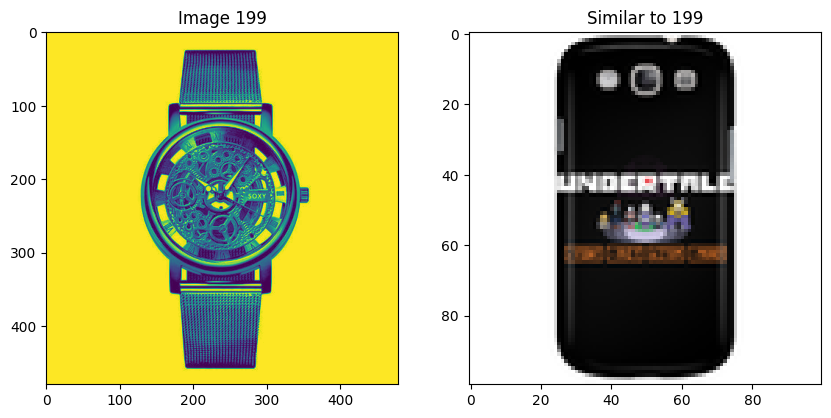

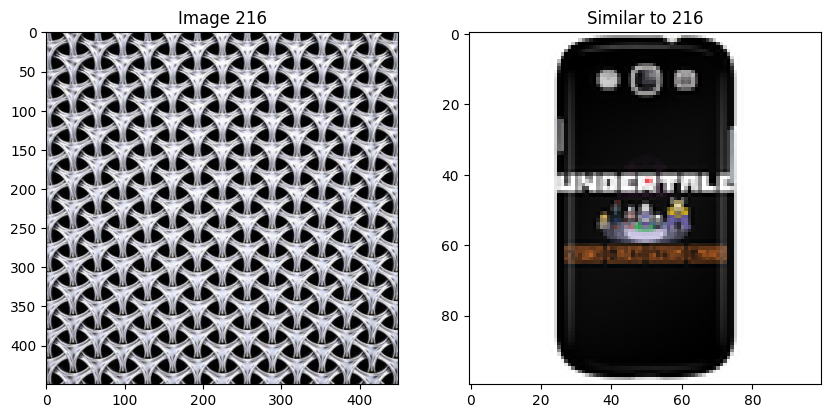

KeyError: 220

In [ ]:
import matplotlib.pyplot as plt

def retrieve_and_show_images(index1, index2_list, dataframe):
    image1 = Image.open(io.BytesIO(dataframe.loc[index1]['BUFFER']))
    plt.figure(figsize=(10, 10))
    plt.subplot(1, len(index2_list) + 1, 1)
    plt.imshow(image1)
    plt.title(f'Image {index1}')
    for j, index2 in enumerate(index2_list, start=2):
        image2 = Image.open(io.BytesIO(dataframe.loc[index2]['BUFFER']))
        plt.subplot(1, len(index2_list) + 1, j)
        plt.imshow(image2)
        plt.title(f'Similar to {index1}')
    plt.show()

# Convert the Dask DataFrame to a Pandas DataFrame for easier indexing

for i, similar_indices in enumerate(similar_pairs):
    # Filter out indices that are too similar (i.e., the same image or very close matches)
    filtered_indices = [idx for idx in similar_indices if idx != i and 1 - (D[i, idx] / 2) > threshold]
    if filtered_indices:
        retrieve_and_show_images(i, filtered_indices, df_pandas)


In [ ]:
import dask.dataframe as dd
import pandas as pd
import torch
from PIL import Image
import io
import clip

# df = filtered_lang_df
df = filtered_df
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("/mnt/data/user/tc_agi/multi_modal/checkpoints/clip/ViT-B-16.pt", device=device)

def generate_batches_from_dask_df(ddf, batch_size):
    num_partitions = ddf.npartitions
    for i in range(num_partitions):
        small_df = ddf.get_partition(i).compute()
        for start in range(0, len(small_df), batch_size):
            end = start + batch_size
            yield small_df.iloc[start:end]

embeddings = []
print("---------------------------------------------")
for batch in generate_batches_from_dask_df(df, batch_size=4000):
    print(f"len: {len(batch)}")
    images = [Image.open(io.BytesIO(row['BUFFER'])) for _, row in batch.iterrows()]
    # tensor = torch.stack([preprocess(img).unsqueeze(0) for img in images]).to(device)
    tensor = torch.stack([preprocess(img) for img in images]).to(device)
    with torch.no_grad():
        embedding = model.encode_image(tensor)
        embeddings.append(embedding.cpu())


---------------------------------------------
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 339
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 247
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 249
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 226
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 138
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 222
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 244
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 356
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 241
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 324
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 213
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 237
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 384
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 283
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 335
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 345
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 292
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 346
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 243
len: 1100


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len: 1100
len: 1100
len: 259


In [ ]:
import torch
from clip import clip
import dask.dataframe as dd
from PIL import Image
import io
df = filtered_lang_df
print(f"len: {len(df)}")
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("/mnt/data/user/tc_agi/multi_modal/checkpoints/clip/ViT-B-16.pt", device=device)
batch_size = 320
# 定义从Dask DataFrame获取批次的迭代器
def generate_batches_from_dask_df(ddf, batch_size):
    num_partitions = ddf.npartitions
    for i in range(num_partitions):
        small_df = ddf.get_partition(i).compute()
        for start in range(0, len(small_df), batch_size):
            end = start + batch_size
            yield small_df.iloc[start:end]
def get_clip_features_for_batches(ddf, batch_size):
    embeddings = []
    index_tracker = []
    for batch in generate_batches_from_dask_df(ddf, batch_size):
        images = [Image.open(io.BytesIO(row['BUFFER'])) for _, row in batch.iterrows()]
        tensor = torch.stack([preprocess(img) for img in images]).to(device)
        with torch.no_grad():
            embedding = model.encode_image(tensor)
            embeddings.extend(embedding.cpu().numpy().tolist())
            index_tracker.extend(batch.index.tolist())
    return embeddings, index_tracker
# 提取特征
embeddings, indices = get_clip_features_for_batches(df, batch_size)
# 使用indices将特征赋值到原始df中
df = df.assign(CLIP_Features=df.index.map({idx: emb for idx, emb in zip(indices, embeddings)}).compute())

len: 3456


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


ValueError: Length of values (3456) does not match length of index (2)

In [ ]:
len(filtered_df)

71523

In [ ]:
df = filtered_lang_df
all_data = [] # 用于存储每个批次的数据和对应的 embeddings
for batch in generate_batches_from_dask_df(df, batch_size=1000):
    images = [Image.open(io.BytesIO(row['BUFFER'])) for _, row in batch.iterrows()]
    tensor = torch.stack([preprocess(img) for img in images]).to(device)
    with torch.no_grad():
        embedding = model.encode_image(tensor)
    embeddings_df = pd.DataFrame(embedding.cpu().numpy())
    batch_with_embeddings = pd.concat([batch.reset_index(drop=True), embeddings_df], axis=1)
    all_data.append(batch_with_embeddings)
result_df = dd.from_pandas(pd.concat(all_data, ignore_index=True), npartitions=df.npartitions)

In [ ]:
# result_df.head(20)
sim_df = result_df[(result_df['similarity']>=0.45)]
sim_df.head(40)

SAMPLE_ID   
500   5.975440e+11  \
1308  4.963710e+11   
1714  3.525187e+12   
2961  3.175175e+12   

                                                                                                                                                                                                                                                                                    URL   
500                                                                                                                                                                     https://rlv.zcache.co.uk/sandy_toes_and_salty_kisses_case-rdc05e547ac91453a9834f78a0840a095_80cs8_8byvr_324.jpg  \
1308                                                                                                                                                         https://rlv.zcache.co.uk/spanish_is_for_people_with_personality_case-rd5620d5158f245659d6d689a1f2f09db_a460e_8byvr_324.jpg   
1714                                                                                                                                                                                                          http://blog.i-glamour.com/wp-content/uploads/2012/02/600616_4-150x150.jpg   
2961  https://render.fineartamerica.com/images/rendered/medium/shower-curtain/images/artworkimages/medium/2/snowy-owl-in-the-dunes-wayne-marshall-chase.jpg?&targetx=-259&targety=0&imagewidth=1305&imageheight=819&modelwidth=787&modelheight=819&backgroundcolor=684738&orientation=0   

                                                                TEXT  HEIGHT   
500                       Sandy Toes And Salty Kisses iPhone 5 Cases     324  \
1308  Spanish Is For People With Personality iPhone 4 Case-Mate Case     324   
1714      Tweezerman ProCurl Eyelash Curler - the new gold standard!     150   
2961                           Snowy Owl In The Dunes Shower Curtain     600   

      WIDTH LICENSE      NSFW  similarity   
500     324       ?  UNLIKELY    0.474679  \
1308    324       ?  UNLIKELY    0.476753   
1714    150       ?  UNLIKELY    0.453735   
2961    600       ?  UNLIKELY    0.456536   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               BUFFER   
500   b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xe1\x01\x0cExif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x01\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x00\x16\x00\x01\x92\x86\x00\x07\x00\x00\x00\xe0\x00\x00\x00$UNICODE\x00\x00I\x00m\x00a\x00g\x00e\x00 \x00l\x00i\x00c\x00e\x00n\x00s\x00e\x00d\x00 \x00t\x00o\x00 \x00Z\x00a\x00z\x00z\x00l\x00e\x00 \x00I\x00n\x00c\x00.\x00 \x00A\x00l\x00l\x00 \x00u\x00n\x00a\x00u\x00t\x00h\x00o\x00r\x00i\x00z\x00e\x00d\x00 \x00u\x00s\x00e\x00 \x00i\x00s\x00 \x00p\x00r\x00o\x00h\x00i\x00b\x00i\x00t\x00e\x00d\x00.\x00 \x00d\x00c\x000\x005\x00e\x005\x004\x007\x00-\x00a\x00c\x009\x001\x00-\x004\x005\x003\x00a\x00-\x009\x008\x003\x004\x00-\x00f\x007\x008\x00a\x000\x008\x004\x000\x00a\x000\x009\x005\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xdb\x00C\x00\x05\x03\

In [ ]:
import torch
from clip import clip
import dask.dataframe as dd
df = filtered_lang_df
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("/mnt/data/user/tc_agi/multi_modal/checkpoints/clip/ViT-B-16.pt", device=device)

def extract_clip_features(img):
    img_bytes = Image.open(io.BytesIO(img))
    # tensor = torch.stack([preprocess(img).unsqueeze(0) for img in images]).to(device)
    image = preprocess(img_bytes).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model.encode_image(image)
    return features.cpu().numpy()

def extract_features_and_append(partition):
    partition['CLIP_Features'] = partition['BUFFER'].map(extract_clip_features)
    return partition

df_with_features = df.map_partitions(extract_features_and_append, meta=df._meta.assign(CLIP_Features='f8'))

In [ ]:
import torch
from clip import clip
import dask.dataframe as dd
from PIL import Image
import io
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("/mnt/data/user/tc_agi/multi_modal/checkpoints/clip/ViT-B-16.pt", device=device)
def extract_clip_features_batch(imgs):
    # 批量加载和预处理图像
    tensors = [preprocess(Image.open(io.BytesIO(img))).unsqueeze(0) for img in imgs]
    tensor = torch.cat(tensors, dim=0).to(device)
    with torch.no_grad():
        features = model.encode_image(tensor)
    return features.cpu().numpy()

def generate_batches_from_dask_df(ddf, batch_size):
    num_partitions = ddf.npartitions
    for i in range(num_partitions):
        small_df = ddf.get_partition(i).compute()
        for start in range(0, len(small_df), batch_size):
            end = start + batch_size
            yield small_df.iloc[start:end]
            
def extract_features_and_append(partition):
    print(f"part : {len(partition)}")
    imgs = partition['BUFFER'].tolist()
    features_batch = extract_clip_features_batch(imgs)
    # 将batch特征分配给各个图像
    partition['CLIP_Features'] = [f for f in features_batch]
    return partition
df_with_features = df.map_partitions(extract_features_and_append, meta=df._meta.assign(CLIP_Features='f8'))

In [ ]:
len(features_computed)


3456

In [ ]:
df_with_features.compute()

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/tmp/ipykernel_996/841927101.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partition['CLIP_Features'] = partition['BUFFER'].map(extract_clip_features)


SAMPLE_ID   
2     1.881504e+12  \
4     1.178721e+12   
6     1.108919e+12   
7     4.183606e+12   
9     4.093572e+12   
...            ...   
9934  1.894439e+12   
9937  3.228430e+12   
9944  2.484560e+12   
9951  1.904424e+12   
9953  2.050215e+12   

                                                                                                                                                             URL   
2                                         http://image.made-in-china.com/43f34j00ujptPGlKsLgB/Economic-Hydraulic-Press-Bending-Machine-Press-Machine-HPB-50-.jpg  \
4                                                                                             https://thumbs.ebaystatic.com/images/g/SK8AAOSw-0xYT7Sw/s-l225.jpg   
6                                                                                             https://thumbs.ebaystatic.com/images/g/mv0AAOSwLF1X-YMv/s-l225.jpg   
7     https://cdn.shopify.com/s/files/1/0038/1842/2339/products/23-5-8-inch-stainless-steel-glass-rinser-drain-tray-2-4-faucets-dp-1605_150x150.jpg?v=1541445553   
9                                                           https://partycity6.scene7.com/is/image/PartyCity/_pdp_sq_?$_1000x1000_$&$product=PartyCity/795360_01   
...                                                                                                                                                          ...   
9934                                                                           https://d3bx4ud3idzsqf.cloudfront.net/public/production/3243/38465_1490119056.jpg   
9937                                                                      https://www.specsserver.com/CACHE/MENFSQGBKXBG.JPG?width=370&height=370&ccid=x66a7a87a   
9944                                                                                           https://i.ebayimg.com/thumbs/images/g/sCcAAMXQWuRQ-pqx/s-l225.jpg   
9951                                                                                                              https://www.iceposter.com/thumbs/G522706_b.jpg   
9953                                 http://images.footballfanatics.com/FFImage/thumb.aspx?i=/productimages/_2774000/altimages/ff_2774721alt2_full.jpg&amp;w=600   

                                                                                                    TEXT   
2                    Economic Hydraulic Press Bending Machine / Press Machine (HPB-50) pictures & photos  \
4                         18 CIRCUIT UNIVERSAL WIRE HARNESS drag race Street Ford hot rod race car Dodge   
6                                                                Sting - Still be Love in the World (CD)   
7                                "23-5/8 Stainless Steel Glass Rinser Drain Tray, 2-4 Faucets # DP-1605"   
9                                                                        White Feather Boas 2ct Image #2   
...                                                                                                  ...   
9934                                                Sobeys_Pillsbury^(TM) S'mores Mini Pies_coupon_25035   
9937                                                         Paxberry - Whitewash 2 Piece Bed Set (Full)   
9944                                BMW 1990 heater and climate control assembly with trim 5 series 535i   
9951                                                                         Terence Hill poster G522706   
9953  Men's New Era Heathered Gray/Black Philadelphia Eagles The League Shadow 2 9FORTY Adjustable Hat 2   

      HEIGHT  WIDTH LICENSE      NSFW  similarity   
2        300    300       ?  UNLIKELY    0.331542  \
4        225    225       ?  UNLIKELY    0.301038   
6        225    225       ?  UNLIKELY    0.440154   
7        150    150       ?  UNLIKELY    0.314222   
9       1000   1000       ?  UNLIKELY    0.338312   
...      ...    ...     ...       ...         ...   
9934     120    120       ?  UNLIKELY    0.403877   
9937     370    370       ?  UNLIKELY    0.320601   
9